In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from collections import namedtuple
import pandas as pd
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import string
import re
#!pip install -U -q PyDrive

# New Section

In [5]:
# Mounting and authenticating
drive.mount('/content/drive')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Reading files from Drive
link_true = 'https://drive.google.com/open?id=1cuYnoKqrG92tLvVY6qinyYzjftrqI1tw'
link_fake = 'https://drive.google.com/open?id=1J75t1Gi4GoHXQQRy1sh7ixS0d7UR3RP3'
_, id_true = link_true.split('=')
_, id_fake = link_fake.split('=')

n = 15000 #reading only 30k/40k
downloaded = drive.CreateFile({'id':id_true}) 
downloaded.GetContentFile('True.csv')  
df_real = pd.read_csv('True.csv')
df_real['response'] = 0
df_real = df_real.head(n)

downloaded = drive.CreateFile({'id':id_fake}) 
downloaded.GetContentFile('Fake.csv')  
df_fakes = pd.read_csv('Fake.csv')
df_fakes['response'] = 1
df_fakes = df_fakes.head(n)

df_total = pd.concat([df_fakes,df_real], axis=0)
df_total['size_text']=df_total.text.str.len()
df_total.shape

In [32]:
df_total.head(5)

,title,text,subject,date,response,size_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,2893
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,1898
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,3597
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,2774
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,2346


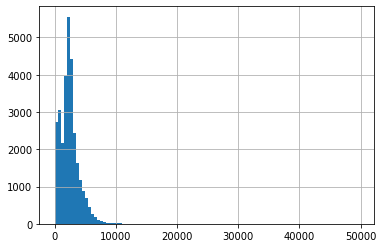

In [37]:
df_total['size_text'].hist(bins=100)

In [41]:
df_total[['size_text']].describe()

,size_text
count,30000.000000
mean,2428.288600
std,1686.960409
min,1.000000
25%,1412.000000
50%,2267.000000
75%,3087.000000
max,49705.000000


In [13]:
# Preprocessing the article text
articles=list(df_total.text)

articles = [article.lower() for article in articles]
table = str.maketrans('', '', string.punctuation)
articles = [article.translate(table) for article in articles]
articles = [re.sub(r'\d+', 'num', article) for article in articles]

print(articles[1])
print(len(articles))

house intelligence committee chairman devin nunes is going to have a bad day he s been under the assumption like many of us that the christopher steeledossier was what prompted the russia investigation so he s been lashing out at the department of justice and the fbi in order to protect trump as it happens the dossier is not what started the investigation according to documents obtained by the new york timesformer trump campaign adviser george papadopoulos was drunk in a wine bar when he revealed knowledge of russian opposition research on hillary clintonon top of that papadopoulos wasn t just a covfefe boy for trump as his administration has alleged he had a much larger role but none so damning as being a drunken fool in a wine bar coffee boys  don t help to arrange a new york meeting between trump and president abdel fattah elsisi of egypt two months before the election it was known before that the former aide set up meetings with world leaders for trump but team trump ran with him b

In [0]:
# Splitting the articules
X= np.array(articles)
y= np.array(df_total.response)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [0]:
# Vectorizing using TFIDF excluding words that don't appear more than 10 times
vectorizer = TfidfVectorizer(min_df=10)
vector_train = vectorizer.fit_transform(X_train)
vector_test = vectorizer.transform(X_test)
feature_names = vectorizer.get_feature_names()

In [20]:
# Checking results
print("vocabulary size:", len(feature_names))
df_tfidf = pd.DataFrame(vector_train.toarray(), columns=feature_names)
df_tfidf.head(5)
#len(feature_names)

vocabulary size: 19818


,aaplo,aaron,aarp,ab,aback,abadi,abandon,abandoned,abandoning,abandonment,abbas,abbe,abbott,abby,abc,abcnum,abcpolitics,abdel,abdication,abdrabbu,abducted,abdul,abdulaziz,abdullah,abe,abedin,abetting,abhor,abhorrent,abide,abiding,abilities,ability,abject,able,ablebodied,abnormal,abnormalities,abnormally,aboard,...,yugoslavia,yuri,zach,zack,zaghariratcliffe,zakharova,zalben,zanupf,zargham,zarif,zarrab,zaw,zayed,zdf,zealand,zealots,zeid,zeitung,zelaya,zeman,zero,zika,zimbabwe,zimbabwean,zimbabweans,zimmerman,zinger,zingers,zinke,zionist,zip,zippers,zoe,zone,zones,zoo,zoomph,zuckerberg,zuma,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020306,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Using support vector machine following the paper second most accurate model
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(vector_train.toarray(), y_train)
y_pred_train=clf.predict(vector_train.toarray())
y_pred_test=clf.predict(vector_test.toarray())

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Training set")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("Validation set")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Training set
[[10596     4]
 [    8 10392]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10600
           1       1.00      1.00      1.00     10400

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000

Validation set
[[4365   35]
 [  48 4552]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4400
           1       0.99      0.99      0.99      4600

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000

